# Proyek Klasifikasi Gambar: Orange Fruit Dataset
- **Nama:** Heriswaya
- **Email:** heriswaya2014@gmail.com
- **ID Dicoding:** heriswaya_

# **About Data**
The orange fruit dataset was gathered using a phone camera in the `HEIC (highly enhanced image container)` format and was converted to `JPEG format`. This dataset was collected in research carried out to determine the dominant diseases affecting oranges in the eastern parts of `Uganda`. It can be used for any artificial intelligence project and any agricultural research by anyone.

# **Objective**
Membangun sebuah model CNN yang dapat mengklasifikasikan penyakit pada jeruk (`Healthy`,`Citrus Canker`,`Melanose`) menggunakan gambar yang diambil di daerah Uganda Timur.

## Import Semua Packages/Library yang Digunakan

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Copy file zip dari Drive ke Colab Workspace
!cp /content/drive/MyDrive/klasifikasi/orange-fruit-dataset.zip /content/

In [5]:
# Unzip dataset
!unzip orange-fruit-dataset.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: FIELD IMAGES/healthy/h (1487).jpg  
  inflating: FIELD IMAGES/healthy/h (1488).jpg  
  inflating: FIELD IMAGES/healthy/h (1489).jpg  
  inflating: FIELD IMAGES/healthy/h (149).jpeg  
  inflating: FIELD IMAGES/healthy/h (149).jpg  
  inflating: FIELD IMAGES/healthy/h (1490).jpg  
  inflating: FIELD IMAGES/healthy/h (1491).jpg  
  inflating: FIELD IMAGES/healthy/h (1492).jpg  
  inflating: FIELD IMAGES/healthy/h (1493).jpg  
  inflating: FIELD IMAGES/healthy/h (1494).jpg  
  inflating: FIELD IMAGES/healthy/h (1495).jpg  
  inflating: FIELD IMAGES/healthy/h (1496).jpg  
  inflating: FIELD IMAGES/healthy/h (1497).jpg  
  inflating: FIELD IMAGES/healthy/h (1498).jpg  
  inflating: FIELD IMAGES/healthy/h (1499).jpg  
  inflating: FIELD IMAGES/healthy/h (15).jpeg  
  inflating: FIELD IMAGES/healthy/h (15).jpg  
  inflating: FIELD IMAGES/healthy/h (150).jpeg  
  inflating: FIELD IMAGES/healthy/h (150).jpg  
  inflating: FI

### Menggabungkan Data `citrus canker`, `healthy`, dan `melanose` ke direktori yang sama

In [6]:
# Direktori asal
origin_dir = "FIELD IMAGES"

# Direktori tujuan
combined_dir = "dataset"

# Buat folder baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

# Salin semua folder kelas (citrus canker, healthy, melanose)
for category in os.listdir(origin_dir):
    category_dir = os.path.join(origin_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

### Menampilkan beberapa gambar dari ketiga kelas

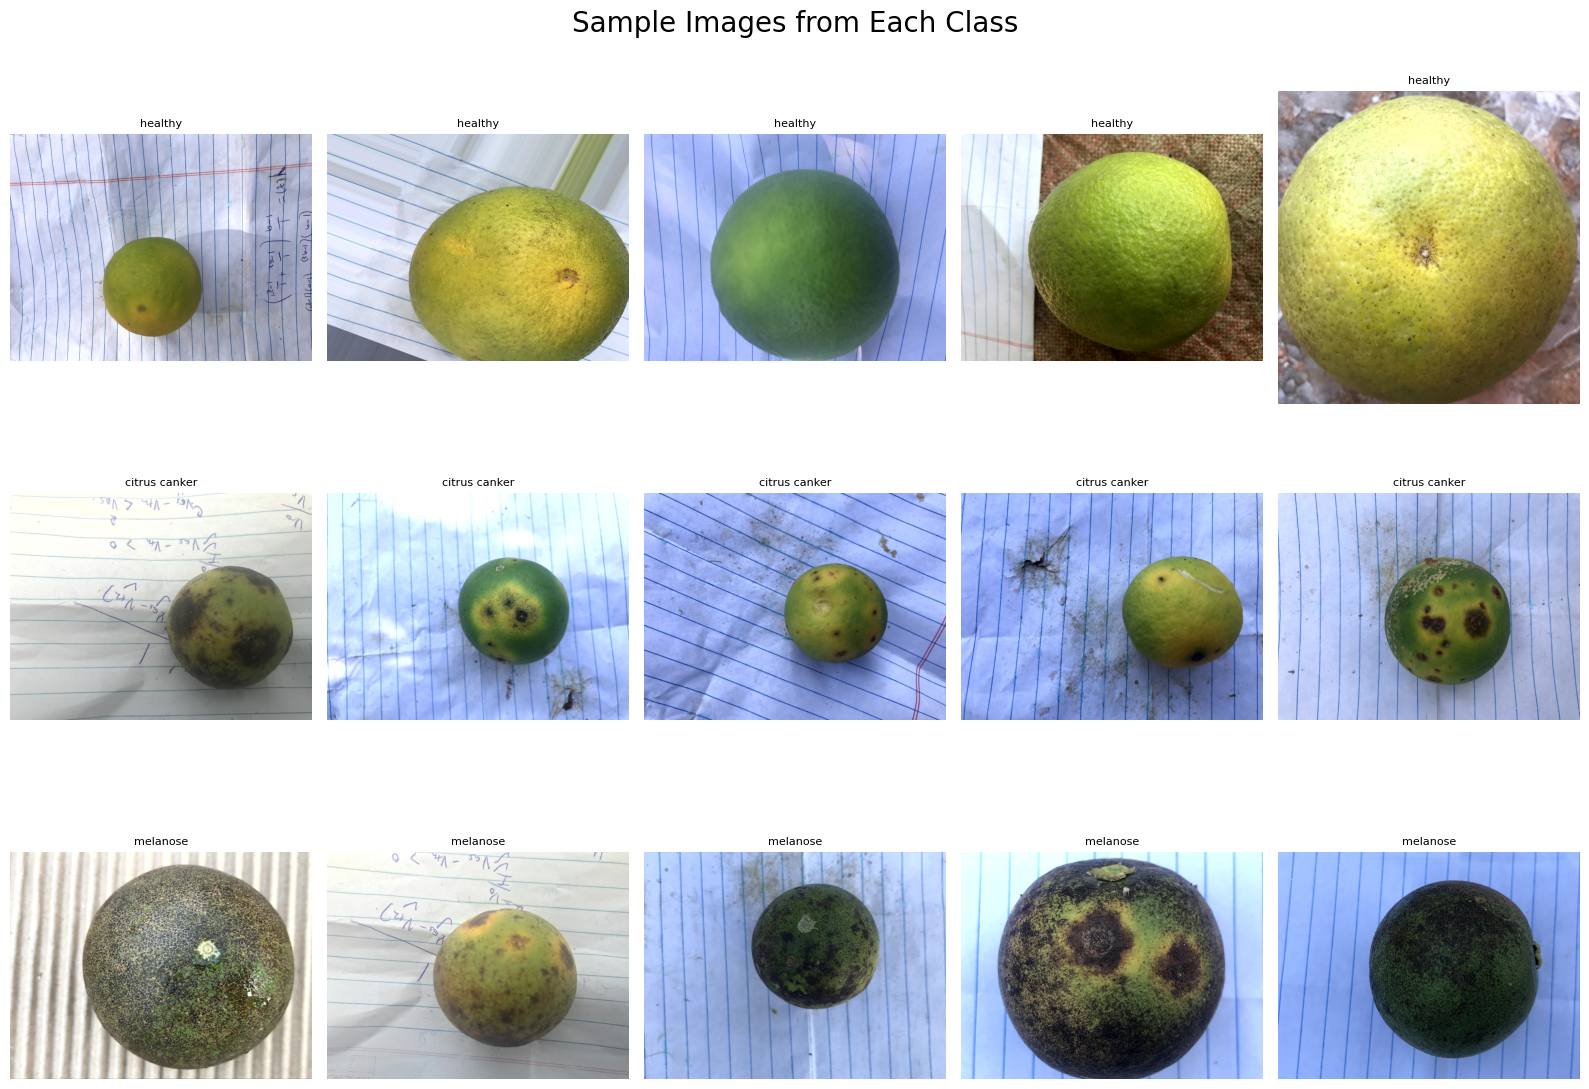

In [7]:
# Membuat kamus untuk menyimpan gambar untuk setiap kelas dalam dataset
orange_images = {}

# Path ke folder dataset gabungan
path = "dataset"
for class_name in os.listdir(path):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):
        orange_images[class_name] = os.listdir(class_path)

# Menampilkan secara acak 5 gambar dari masing-masing kelas
fig, axs = plt.subplots(len(orange_images.keys()), 5, figsize=(16, 12))  # ukuran figurenya dibesarkan sedikit

for i, class_name in enumerate(orange_images.keys()):
    images = np.random.choice(orange_images[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path).convert("RGB")  # gambar pada dataset berwarna, jadi pakai RGB
        axs[i, j].imshow(img)
        axs[i, j].set_title(class_name, fontsize=8)  # kasih title kecil di atas gambar
        axs[i, j].axis('off')  # hilangkan axis supaya lebih clean

fig.suptitle('Sample Images from Each Class', fontsize=20)
fig.tight_layout()
plt.show()

### Plot Distribusi gambar diseluruh kelas

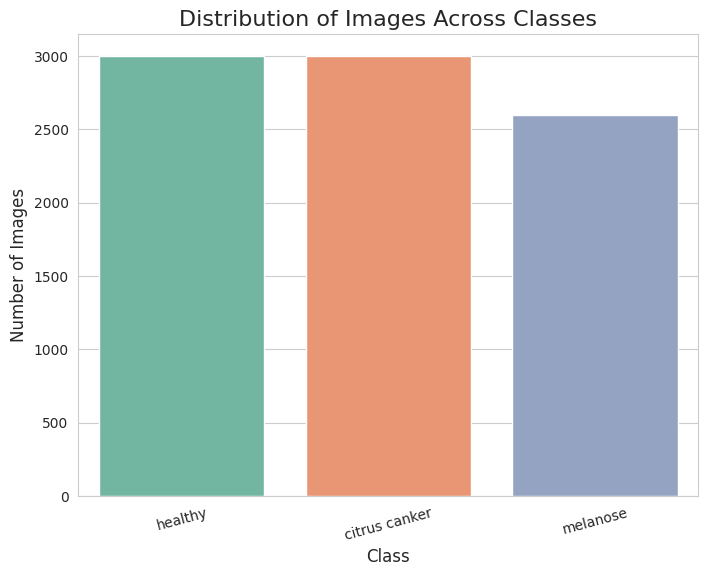

In [8]:
# Path ke folder dataset
orange_path = "dataset/"

# List untuk menyimpan informasi file
file_names = []
labels = []
full_paths = []

# Loop untuk mengambil semua file dan label
for path_dir, subdirs, files in os.walk(orange_path):
    for file_name in files:
        full_path = os.path.join(path_dir, file_name)
        label = os.path.basename(path_dir)  # ambil nama folder sebagai label

        full_paths.append(full_path)
        file_names.append(file_name)
        labels.append(label)

# Membuat DataFrame
orange_df = pd.DataFrame({
    "file_name": file_names,
    "path": full_paths,
    "label": labels
})

# Plot distribusi jumlah gambar per kelas
plt.figure(figsize=(8,6))
sns.set_style("whitegrid")
sns.countplot(data=orange_df, x='label', palette="Set2")

plt.title('Distribution of Images Across Classes', fontsize=16)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=15)
plt.show()

### Data Augmentation

Berikut adalah beberapa teknik augmentasi yang digunakan:

1. Rotasi (`Clockwise` dan `Anticlockwise`): Untuk menangani gambar jeruk dengan berbagai orientasi.

2. `Flip Horizontal` dan `Vertikal`: Menghasilkan variasi tampilan jeruk tanpa mengubah kandungan visual.

3. Pergeseran Acak (Translation): Untuk menggeser gambar agar model dapat mempelajari perbedaan posisi objek.

4. Perubahan `Kecerahan` dan `Kontras`: Untuk menangani variasi pencahayaan dalam foto.

5. `blur`: ketika gambar diberikan efek kabur atau blur.

6. `Shearing`: Agar model dapat mengenali bentuk jeruk dalam sudut pandang yang sedikit miring.

7. `wrap_shift`: ketika gambar diberikan efek pergeseran melengkung.

In [9]:
# Fungsi rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.choice([1, 2, 3]))  # Rotasi 90, 180, 270 derajat
    return img

# Fungsi rotasi searah jarum jam
def clockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=4 - random.choice([1, 2, 3]))  # Rotasi searah jarum jam
    return img

# Fungsi flip gambar atas ke bawah
def flip_up_down(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.flip_up_down(img)
    return img

# Fungsi untuk membalik gambar secara horizontal
def flip_left_right(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.flip_left_right(img)
    return img

# Fungsi meningkatkan kecerahan gambar
def add_brightness(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.adjust_brightness(img, delta=random.uniform(0.2, 0.5))  # Naikkan kecerahan
    return img

# Fungsi untuk melakukan perubahan kontras pada gambar
def add_contrast(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.random_contrast(img, lower=0.7, upper=1.3)  # Sesuaikan nilai kontras
    return img

# Fungsi untuk mengkaburkan (blur) gambar
def blur_image(img):
    img = tf.image.resize(img, (224, 224))
    img = img.numpy()  # Convert ke numpy dulu
    img = cv2.GaussianBlur(img, (5, 5), 0)  # Blur kernel 5x5
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    return img

# Fungsi shear (miringkan gambar)
def sheared(img):
    img = tf.image.resize(img, (224, 224))
    datagen = ImageDataGenerator(shear_range=20)  # shear 20 derajat
    img = next(iter(datagen.flow(tf.expand_dims(img, 0), batch_size=1)))[0]
    return img

# Fungsi shift gambar (warp sedikit)
def warp_shift(img):
    img = tf.image.resize(img, (224, 224))
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)  # geser 10%
    img = next(iter(datagen.flow(tf.expand_dims(img, 0), batch_size=1)))[0]
    return img

In [16]:
# fungsi untuk mengubah dimensi gambar selaras
def resize_with_padding(image, desired_size=224):
    """Resize image sambil mempertahankan rasio dan memberi padding supaya jadi persegi."""
    old_size = image.shape[:2]  # (height, width)

    ratio = float(desired_size) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])

    # Resize gambar
    resized_image = cv2.resize(image, (new_size[1], new_size[0]))

    # Buat padding
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    color = [255, 255, 255]  # Putih sebagai padding
    new_im = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return new_im

# Dictionary transformasi
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'flip up down': flip_up_down,
    'flip left right': flip_left_right,
    'add brightness': add_brightness,
    'add contrast': add_contrast,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'shear image': sheared
}

# Path dataset
images_path = "dataset/melanose"  # Folder utama
augmented_path = "dataset/melanose"  # Folder hasil augmentasi

images = []

# Membaca semua gambar dari seluruh subfolder
for subdir, dirs, files in os.walk(images_path):
    for file in files:
        file_path = os.path.join(subdir, file)
        images.append(file_path)

# Tentukan jumlah gambar augmentasi yang ingin dibuat
images_to_generate = 400
i = 1

while i <= images_to_generate:
    image = random.choice(images)
    try:
        original_image = io.imread(image)

        original_image = resize_with_padding(original_image, desired_size=224)
        if original_image.dtype != np.float32:
            if original_image.max() > 1.0:
              original_image = original_image / 255.0
            original_image = original_image.astype(np.float32)


        # Pastikan gambar valid (RGB / RGBA)
        if original_image.ndim == 3 and original_image.shape[2] not in [3, 4]:
          raise ValueError('Invalid number of channels')


        # Konversi gambar asli ke Tensor
        transformed_image = tf.convert_to_tensor(original_image, dtype=tf.float32)

        n = 0
        transformation_count = random.randint(1, len(transformations))  # Random berapa banyak augmentasi akan diterapkan

        while n < transformation_count:
            key = random.choice(list(transformations))
            transformed_image = transformations[key](transformed_image)
            n += 1

        # Simpan gambar hasil augmentasi
        new_image_path = f"{augmented_path}/augmented_image_{i}.jpg"
        transformed_image = img_as_ubyte(transformed_image)
        cv2.imwrite(new_image_path, cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR))
        i += 1

    except (ValueError, Exception) as e:
      print('Could not read or process the image', image, ':', e, 'hence skipping it.')

Could not read or process the image dataset/melanose/m (1639).jpg : Images of type float must be between -1 and 1. hence skipping it.
Could not read or process the image dataset/melanose/m (1619).jpg : Images of type float must be between -1 and 1. hence skipping it.
Could not read or process the image dataset/melanose/m (763).jpg : Images of type float must be between -1 and 1. hence skipping it.
Could not read or process the image dataset/melanose/m (1233).jpg : Images of type float must be between -1 and 1. hence skipping it.
Could not read or process the image dataset/melanose/m (1774).jpg : Images of type float must be between -1 and 1. hence skipping it.
Could not read or process the image dataset/melanose/m (92).jpg : Images of type float must be between -1 and 1. hence skipping it.
Could not read or process the image dataset/melanose/m (156).jpg : Images of type float must be between -1 and 1. hence skipping it.
Could not read or process the image dataset/melanose/m (540).jpg :

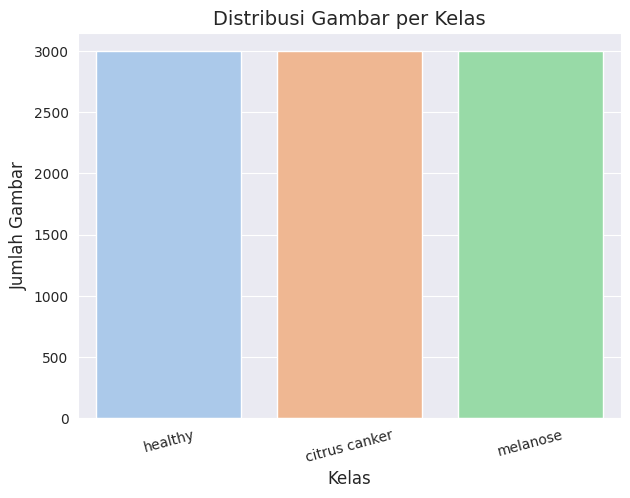

In [17]:
# Path ke folder dataset
orange_path = "dataset/"

# List untuk menyimpan informasi file
file_name = []
labels = []
full_path = []

# Baca semua gambar dari seluruh subfolder
for path, subdirs, files in os.walk(orange_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(os.path.basename(path))  # Ambil nama folder sebagai label
        file_name.append(name)

# Buat DataFrame
orange_df = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

# Plot distribusi gambar tiap kelas
plt.figure(figsize=(7, 5))
sns.set_style("darkgrid")
sns.countplot(data=orange_df, x='labels', order=orange_df['labels'].value_counts().index, palette="pastel")
plt.title("Distribusi Gambar per Kelas", fontsize=14)
plt.xlabel("Kelas", fontsize=12)
plt.ylabel("Jumlah Gambar", fontsize=12)
plt.xticks(rotation=15)
plt.show()

### Data Preprocessing

#### Split Dataset

In [18]:
# Path dataset utama
mypath = 'dataset/'

# Ambil semua path gambar, file name, dan label
file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(mypath):
    for name in files:
        if name.endswith(('.jpg', '.jpeg', '.png')):
            full_path.append(os.path.join(path, name))
            labels.append(path.split('/')[-1])
            file_name.append(name)

# Buat DataFrame awal
df = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

# Cek distribusi data per label
print('Distribusi awal dataset:')
print(df.groupby(['labels']).size())
print('===================================================== \n')

Distribusi awal dataset:
labels
citrus canker    3000
healthy          3000
melanose         3000
dtype: int64



In [19]:
# Variabel untuk split
X = df['path']
y = df['labels']

# Split pertama: Train + (Val + Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Split kedua: Val + Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [20]:
# Buat DataFrame untuk masing-masing set
df_tr = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_val = pd.DataFrame({'path': X_val, 'labels': y_val, 'set': 'val'})
df_te = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})

In [21]:
# Gabungkan semuanya
df_all = pd.concat([df_tr, df_val, df_te], ignore_index=True)

# Tampilkan ringkasan hasil
print('Distribusi setelah split:')
print(df_all.groupby(['set', 'labels']).size())
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))

Distribusi setelah split:
set    labels       
test   citrus canker     450
       healthy           450
       melanose          450
train  citrus canker    2100
       healthy          2100
       melanose         2100
val    citrus canker     450
       healthy           450
       melanose          450
dtype: int64

                                    path         labels    set
130         dataset/melanose/m (797).jpg       melanose  train
5401  dataset/citrus canker/c (3089).jpg  citrus canker  train
6473       dataset/melanose/m (2452).jpg       melanose    val
1998       dataset/melanose/m (1195).jpg       melanose  train
4258        dataset/melanose/m (296).jpg       melanose  train


In [22]:
# Path dataset sumber (asli)
datasource_path = "dataset/"

# Path dataset tujuan (hasil split train/val/test)
dataset_path = "dataset-final/"

In [23]:
from tqdm import tqdm

# Loop semua data di df_all
for index, row in tqdm(df_all.iterrows(), total=df_all.shape[0]):
    # Ambil path file dari DataFrame
    file_path = row['path']

    # Kalau file_path tidak ditemukan, coba cek alternatif path (opsional, biasanya tidak perlu)
    if not os.path.exists(file_path):
        file_path = os.path.join(datasource_path, row['labels'], row['file_name'])

    # Buat folder tujuan jika belum ada
    dest_folder = os.path.join(dataset_path, row['set'], row['labels'])
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)

    # Tentukan nama file tujuan
    destination_file_name = os.path.basename(file_path)
    file_dest = os.path.join(dest_folder, destination_file_name)

    # Salin file jika belum ada
    if not os.path.exists(file_dest):
        shutil.copy2(file_path, file_dest)

100%|██████████| 9000/9000 [01:02<00:00, 144.86it/s]


### Image Data Generator

In [24]:
# Define training, validation, and test directories
TRAIN_DIR = "dataset-final/train/"
VAL_DIR = "dataset-final/val/"
TEST_DIR = "dataset-final/test/"

# Cek jumlah file masing-masing kelas di train, val, test
for label in ['citrus canker', 'melanose', 'healthy']:
    print(f"Total number of {label} images in training set:", len(os.listdir(os.path.join(TRAIN_DIR, label))))
    print(f"Total number of {label} images in validation set:", len(os.listdir(os.path.join(VAL_DIR, label))))
    print(f"Total number of {label} images in test set:", len(os.listdir(os.path.join(TEST_DIR, label))))
    print('---')

Total number of citrus canker images in training set: 2100
Total number of citrus canker images in validation set: 450
Total number of citrus canker images in test set: 450
---
Total number of melanose images in training set: 2100
Total number of melanose images in validation set: 450
Total number of melanose images in test set: 450
---
Total number of healthy images in training set: 2100
Total number of healthy images in validation set: 450
Total number of healthy images in test set: 450
---


In [25]:
# ImageDataGenerator untuk train dan val
train_val_datagen = ImageDataGenerator(
    rescale=1./255
)

# ImageDataGenerator untuk test (hanya rescale)
test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Buat train generator
train_generator = train_val_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),  # sesuai resize kamu tadi
    batch_size=32,
    class_mode='categorical',  # karena 3 kelas
    shuffle=True,
    subset='training',
    color_mode='rgb'  # gambar kamu berwarna
)

# Buat validation generator
val_generator = train_val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    subset='validation',
    color_mode='rgb'
)

# Buat test generator
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb'
)

Found 6300 images belonging to 3 classes.
Found 1350 images belonging to 3 classes.
Found 1350 images belonging to 3 classes.


## Modelling

In [35]:
# Clear session dulu biar bersih
tf.keras.backend.clear_session()

# Load InceptionV3 tanpa top layer
base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)  # karena InceptionV3 butuh 3 channel (RGB)
)

# Bekukan (freeze) base model supaya tidak di-train
base_model.trainable = False

# Buat model baru di atas base model
model = Sequential([
    tf.keras.layers.Input(shape=(224,224,3)),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 kelas: melanose, scab, healthy
])

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',  # multiclass
    metrics=['accuracy']
)

# Print ringkasan model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,065,443 (84.17 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [36]:
# Definisikan callbacks
callbacks = [
    ModelCheckpoint(
        filepath='best_model.h5',  # nama file hasil model terbaik
        monitor='val_accuracy',    # memonitor validation accuracy
        mode='max',                # karena ingin yang akurasinya paling tinggi
        save_best_only=True,       # hanya simpan model terbaik
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',    # memantau validation accuracy
        mode='max',
        patience=8,                # sabar menunggu 8 epoch
        verbose=1,
        restore_best_weights=True  # kembali ke bobot terbaik saat stuck
    )
]

In [37]:
# Hitung jumlah data masing-masing kelas di training set
count_melanose = len(os.listdir(TRAIN_DIR + '/melanose'))
count_citrus_canker = len(os.listdir(TRAIN_DIR + '/citrus canker'))
count_healthy = len(os.listdir(TRAIN_DIR + '/healthy'))

# Hitung bobot untuk masing-masing kelas
total = count_melanose + count_citrus_canker + count_healthy
weight_melanose = (1 / count_melanose) * (total) / 3.0
weight_scab = (1 / count_citrus_canker) * (total) / 3.0
weight_healthy = (1 / count_healthy) * (total) / 3.0

# Simpan class_weights dalam dictionary
class_weights = {0: weight_melanose, 1: weight_scab, 2: weight_healthy}

# Print hasil untuk memastikan
print(class_weights)

{0: 1.0, 1: 1.0, 2: 1.0}


In [38]:
# Training model
%time

history = model.fit(
    train_generator,
    epochs=30,
    batch_size=64,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weights
)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.3 µs
Epoch 1/30
170/197 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8115 - loss: 0.4706

KeyboardInterrupt: 

## Evaluasi dan Visualisasi

In [ ]:
# Mengambil nilai dari history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Membuat range jumlah epoch
epochs = range(len(acc))

# Plot Akurasi
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot Loss
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Reset test generator
test_generator.reset()

# Predict test data
preds = model.predict(test_generator, verbose=0)

# Konversi prediksi probabilitas ke label 0 dan 1
preds = preds.copy()
preds[preds <= 0.5] = 0
preds[preds > 0.5] = 1

# Confusion Matrix
cm = pd.DataFrame(
    data=confusion_matrix(test_generator.classes, preds, labels=[0,1]),
    index=["Actual Normal", "Actual Pneumonia"],
    columns=["Predicted Normal", "Predicted Pneumonia"]
)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(
    y_true=test_generator.classes,
    y_pred=preds,
    target_names=['Normal','Pneumonia'],
    digits=4
))

## Konversi Model

## Inference (Optional)